## POS tagging using modified Viterbi

### Data Preparation

In [4]:
#Importing libraries
import nltk, re, pprint
import numpy as np
import pandas as pd
import requests
import matplotlib.pyplot as plt
import seaborn as sns
import pprint, time
import random
from sklearn.model_selection import train_test_split
from nltk.tokenize import word_tokenize

In [5]:
# reading the Treebank tagged sentences
nltk_data = list(nltk.corpus.treebank.tagged_sents(tagset='universal'))

In [6]:
print(nltk_data[:40]) 

[[('Pierre', 'NOUN'), ('Vinken', 'NOUN'), (',', '.'), ('61', 'NUM'), ('years', 'NOUN'), ('old', 'ADJ'), (',', '.'), ('will', 'VERB'), ('join', 'VERB'), ('the', 'DET'), ('board', 'NOUN'), ('as', 'ADP'), ('a', 'DET'), ('nonexecutive', 'ADJ'), ('director', 'NOUN'), ('Nov.', 'NOUN'), ('29', 'NUM'), ('.', '.')], [('Mr.', 'NOUN'), ('Vinken', 'NOUN'), ('is', 'VERB'), ('chairman', 'NOUN'), ('of', 'ADP'), ('Elsevier', 'NOUN'), ('N.V.', 'NOUN'), (',', '.'), ('the', 'DET'), ('Dutch', 'NOUN'), ('publishing', 'VERB'), ('group', 'NOUN'), ('.', '.')], [('Rudolph', 'NOUN'), ('Agnew', 'NOUN'), (',', '.'), ('55', 'NUM'), ('years', 'NOUN'), ('old', 'ADJ'), ('and', 'CONJ'), ('former', 'ADJ'), ('chairman', 'NOUN'), ('of', 'ADP'), ('Consolidated', 'NOUN'), ('Gold', 'NOUN'), ('Fields', 'NOUN'), ('PLC', 'NOUN'), (',', '.'), ('was', 'VERB'), ('named', 'VERB'), ('*-1', 'X'), ('a', 'DET'), ('nonexecutive', 'ADJ'), ('director', 'NOUN'), ('of', 'ADP'), ('this', 'DET'), ('British', 'ADJ'), ('industrial', 'ADJ'), ('

In [7]:
random.seed(1234)
tr_set, ts_set = train_test_split(nltk_data, test_size=0.05)

print(len(tr_set))
print(len(ts_set))
print(tr_set[:40]) 

3718
196
[[('He', 'PRON'), ('is', 'VERB'), ('an', 'DET'), ('avid', 'ADJ'), ('fan', 'NOUN'), ('of', 'ADP'), ('a', 'DET'), ('proposition', 'NOUN'), ('on', 'ADP'), ('next', 'ADJ'), ('week', 'NOUN'), ("'s", 'PRT'), ('ballot', 'NOUN'), ('0', 'X'), ('*', 'X'), ('to', 'PRT'), ('help', 'VERB'), ('*-2', 'X'), ('build', 'VERB'), ('a', 'DET'), ('replacement', 'NOUN'), ('for', 'ADP'), ('Candlestick', 'NOUN'), ('Park', 'NOUN'), ('*T*-1', 'X'), ('.', '.')], [('Traditionally', 'ADV'), (',', '.'), ('the', 'DET'), ('card', 'NOUN'), ('has', 'VERB'), ('been', 'VERB'), ('used', 'VERB'), ('*-66', 'X'), ('mainly', 'ADV'), ('for', 'ADP'), ('travel', 'NOUN'), ('and', 'CONJ'), ('entertainment', 'NOUN'), ('expenses', 'NOUN'), ('.', '.')], [('Big', 'NOUN'), ('Board', 'NOUN'), ('stock', 'NOUN'), ('specialists', 'NOUN'), (',', '.'), ('in', 'ADP'), ('a', 'DET'), ('bold', 'ADJ'), ('palace', 'NOUN'), ('revolt', 'NOUN'), (',', '.'), ('began', 'VERB'), ('shortly', 'ADV'), ('after', 'ADP'), ('Oct.', 'NOUN'), ('13', 'NUM

In [8]:
# Get list of tagged words
tr_tagd_wrds = [tup for sent in tr_set for tup in sent] 
len(tr_tagd_wrds) 

95495

In [9]:
# Get tokens
tokens = [pair[0] for pair in tr_tagd_wrds] 
tokens[:20] 

['He',
 'is',
 'an',
 'avid',
 'fan',
 'of',
 'a',
 'proposition',
 'on',
 'next',
 'week',
 "'s",
 'ballot',
 '0',
 '*',
 'to',
 'help',
 '*-2',
 'build',
 'a']

In [10]:
# Build vocabulary
vocab = set(tokens)
print(len(vocab)) 

12054


In [11]:
# Find out the number of tags
tgs = set([pair[1] for pair in tr_tagd_wrds])
print(len(tgs))
print(tgs) 

12
{'NUM', 'X', 'ADJ', 'PRON', 'PRT', 'DET', 'ADV', 'CONJ', 'ADP', '.', 'NOUN', 'VERB'}


There are 12 tags that are a part of the universal tagset.

### Build the vanilla Viterbi based POS tagger

In [12]:
# Create a numpy array of the number of POS tags by total vocabulary
T = len(tgs)
V = len(vocab)
w_given_t = np.zeros((T,V)) 

In [13]:
# Compute the word given tag emission probability

def word_given_tag(word, tag, train_bag = tr_tagd_wrds):
    tg_list = [pair for pair in train_bag if pair[1] == tag]
    count_tg = len(tg_list)
    w_given_tg_list = [pair[0] for pair in tg_list if pair[0] == word]
    count_w_given_tg = len(w_given_tg_list)
    
    return (count_w_given_tg, count_tg) 

In [14]:
# Compute the tag given tag: tag2(t2) given tag1(t1) i.e. Tranition probability

def t2_given_t1(t2, t1, train_bag = tr_tagd_wrds):
    tgs = [pair[1] for pair in train_bag]
    count_t1 = len([t for t in tgs if t == t1])
    count_t2_t1 = 0
    for index in range(len(tgs) - 1):
        if tgs[index] == t1 and tgs[index+1] == t2:
            count_t2_t1 += 1
    return (count_t2_t1, count_t1) 

Create a txt (POS tags x POS tags) transition matrix of tags where each column is t2 and each row is t1. Thus, $M(i,j)$ represents $P(t_j|t_i)$.    

In [15]:
tgs_matrix = np.zeros((len(tgs), len(tgs)), dtype = 'float32')
for i, t1 in enumerate(list(tgs)):
    for j, t2 in enumerate(list(tgs)):
        tgs_matrix[i,j] = t2_given_t1(t2, t1)[0]/t2_given_t1(t2, t1)[1] 
        
print(tgs_matrix) 

[[1.86350152e-01 2.11572707e-01 3.32344212e-02 1.48367952e-03
  2.61127595e-02 2.96735903e-03 2.96735903e-03 1.24629084e-02
  3.20474766e-02 1.17210686e-01 3.56379837e-01 1.72106829e-02]
 [2.85895797e-03 7.54447281e-02 1.65184252e-02 5.55908531e-02
  1.83926299e-01 5.35260476e-02 2.55717915e-02 1.04828458e-02
  1.43583223e-01 1.64707750e-01 6.30559102e-02 2.04733163e-01]
 [2.11535282e-02 2.13187896e-02 6.64352998e-02 6.61047758e-04
  1.09072877e-02 4.95785801e-03 4.79259621e-03 1.65261943e-02
  7.84994215e-02 6.49479404e-02 6.98066413e-01 1.17335981e-02]
 [7.29086716e-03 9.28626284e-02 7.29086697e-02 7.29086716e-03
  1.30468151e-02 9.59324650e-03 3.49194184e-02 5.37221786e-03
  2.26400606e-02 3.95241752e-02 2.09132776e-01 4.85418260e-01]
 [5.81319407e-02 1.40431095e-02 8.39320719e-02 1.76355317e-02
  1.95950363e-03 1.02220774e-01 1.04506854e-02 2.28608749e-03
  2.09013708e-02 4.24559116e-02 2.46897459e-01 3.99085552e-01]
 [2.21281741e-02 4.47400250e-02 2.06045955e-01 3.74848861e-03
  1

In [16]:
tgs_df = pd.DataFrame(tgs_matrix, columns=list(tgs), index=list(tgs))
tgs_df

,NUM,X,ADJ,PRON,PRT,DET,ADV,CONJ,ADP,.,NOUN,VERB
NUM,0.186350,0.211573,0.033234,0.001484,0.026113,0.002967,0.002967,0.012463,0.032047,0.117211,0.356380,0.017211
X,0.002859,0.075445,0.016518,0.055591,0.183926,0.053526,0.025572,0.010483,0.143583,0.164708,0.063056,0.204733
ADJ,0.021154,0.021319,0.066435,0.000661,0.010907,0.004958,0.004793,0.016526,0.078499,0.064948,0.698066,0.011734
PRON,0.007291,0.092863,0.072909,0.007291,0.013047,0.009593,0.034919,0.005372,0.022640,0.039524,0.209133,0.485418
PRT,0.058132,0.014043,0.083932,0.017636,0.001960,0.102221,0.010451,0.002286,0.020901,0.042456,0.246897,0.399086
DET,0.022128,0.044740,0.206046,0.003748,0.000121,0.005441,0.012817,0.000363,0.009432,0.017412,0.638452,0.039299
ADV,0.031095,0.022825,0.127357,0.015217,0.013893,0.068806,0.080384,0.006947,0.120079,0.136619,0.031426,0.345352
CONJ,0.040930,0.008372,0.116279,0.059070,0.004651,0.120465,0.054419,0.000465,0.053488,0.035349,0.349302,0.157209
ADP,0.062667,0.035779,0.105195,0.070380,0.001500,0.322871,0.013283,0.000857,0.017247,0.040064,0.321585,0.008570
.,0.081322,0.027287,0.043768,0.065922,0.002251,0.174081,0.052414,0.058087,0.091048,0.093210,0.221632,0.088887


In [17]:
tgs_df.loc['.',:] 

NUM     0.081322
X       0.027287
ADJ     0.043768
PRON    0.065922
PRT     0.002251
DET     0.174081
ADV     0.052414
CONJ    0.058087
ADP     0.091048
.       0.093210
NOUN    0.221632
VERB    0.088887
Name: ., dtype: float32

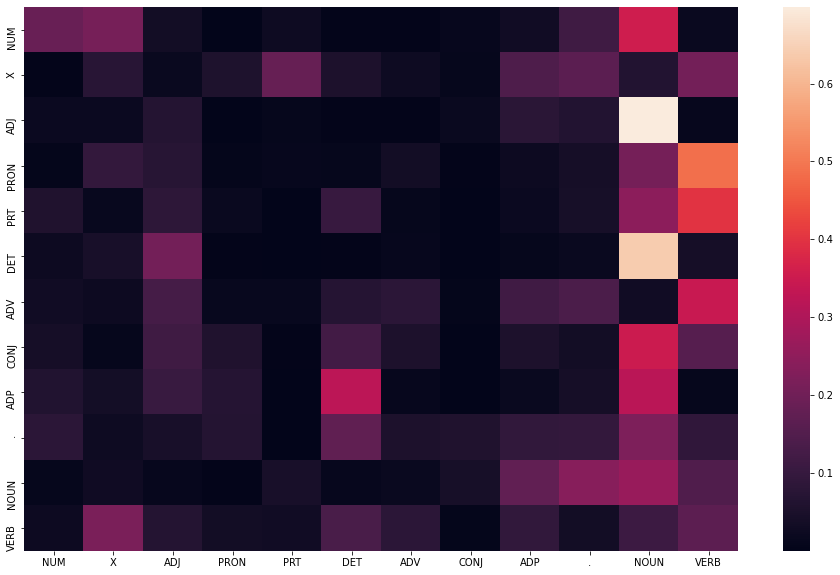

In [18]:
# Heatmap of tgs_df
plt.figure(figsize=(16,10))
sns.heatmap(tgs_df)
plt.show() 

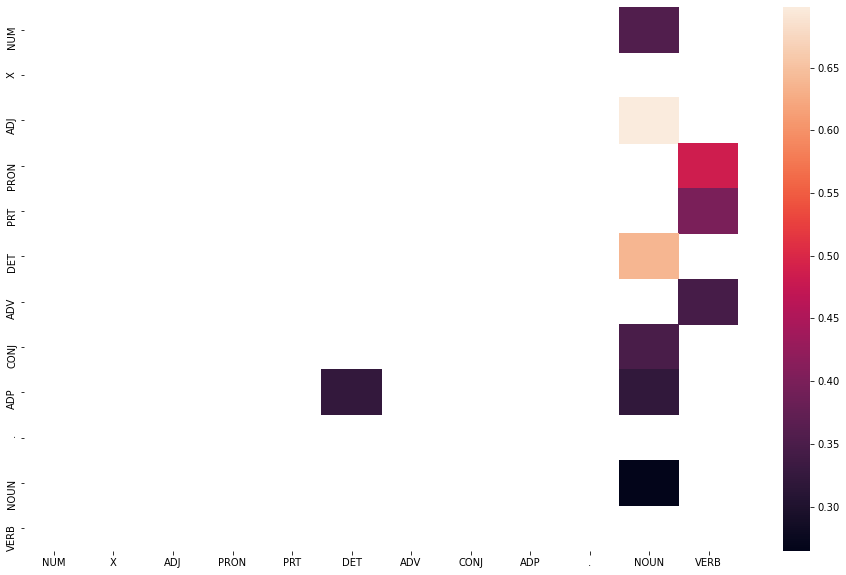

In [19]:
# Find frequent tags P(t2|t1) > 0.25
freq_tgs = tgs_df[tgs_df>0.25]
plt.figure(figsize=(16,10))
sns.heatmap(freq_tgs)
plt.show() 

In [20]:
len(tr_tagd_wrds) 

95495

In [22]:
# Viterbi Heuristic
def Viterbi(words, train_bag = tr_tagd_wrds):
    state =[]
    T = list(set([pair[1] for pair in train_bag]))
    
    for key, word in enumerate(words):
        p = []
        for tag in T:
            if key == 0:
                transition_p = tgs_df.loc['.', tag]
            else:
                transition_p = tgs_df.loc[state[-1], tag]
            
            emission_p = word_given_tag(words[key], tag)[0]/word_given_tag(words[key], tag)[1]
            state_probability = emission_p * transition_p
            p.append(state_probability)
            
        pmax = max(p)
        state_max = T[p.index(pmax)]
        state.append(state_max)
    return list(zip(words, state)) 

In [23]:
random.seed(1234)

rndom = [random.randint(1, len(ts_set)) for x in range(5)]

test_run = [ts_set[i] for i in rndom]

test_run_base = [tup for sent in test_run for tup in sent]

test_tagged_words = [tup[0] for sent in test_run for tup in sent]
test_run

[[('Mr.', 'NOUN'),
  ('Taccetta', 'NOUN'),
  ('says', 'VERB'),
  ('0', 'X'),
  ('he', 'PRON'),
  ('had', 'VERB'),
  ('just', 'ADV'),
  ('recouped', 'VERB'),
  ('the', 'DET'),
  ('$', '.'),
  ('5,000', 'NUM'),
  ('*U*', 'X'),
  ('0', 'X'),
  ('he', 'PRON'),
  ('lost', 'VERB'),
  ('*T*-1', 'X'),
  ('in', 'ADP'),
  ('the', 'DET'),
  ('1987', 'NUM'),
  ('crash', 'NOUN'),
  ('when', 'ADV'),
  ('he', 'PRON'),
  ('lost', 'VERB'),
  ('more', 'ADJ'),
  ('money', 'NOUN'),
  ('last', 'ADJ'),
  ('Oct.', 'NOUN'),
  ('13', 'NUM'),
  ('*T*-2', 'X'),
  ('.', '.')],
 [('Sir', 'NOUN'),
  ('Peter', 'NOUN'),
  ('Walters', 'NOUN'),
  (',', '.'),
  ('58-year-old', 'ADJ'),
  ('chairman', 'NOUN'),
  ('of', 'ADP'),
  ('British', 'NOUN'),
  ('Petroleum', 'NOUN'),
  ('Co.', 'NOUN'),
  ('until', 'ADP'),
  ('next', 'ADJ'),
  ('March', 'NOUN'),
  (',', '.'),
  ('joins', 'VERB'),
  ('the', 'DET'),
  ('board', 'NOUN'),
  ('of', 'ADP'),
  ('this', 'DET'),
  ('cement', 'NOUN'),
  ('products', 'NOUN'),
  ('company', 'NO

In [24]:
# Tag the test sentences
start = time.time()
tagged_seq = Viterbi(test_tagged_words)
end = time.time()
difference = end-start
print("time taken in seconds: ", difference)
print(tagged_seq) 

time taken in seconds:  51.45268225669861
[('Mr.', 'NOUN'), ('Taccetta', 'NOUN'), ('says', 'VERB'), ('0', 'X'), ('he', 'PRON'), ('had', 'VERB'), ('just', 'ADV'), ('recouped', 'NUM'), ('the', 'DET'), ('$', '.'), ('5,000', 'NUM'), ('*U*', 'X'), ('0', 'X'), ('he', 'PRON'), ('lost', 'VERB'), ('*T*-1', 'X'), ('in', 'ADP'), ('the', 'DET'), ('1987', 'NUM'), ('crash', 'NOUN'), ('when', 'ADV'), ('he', 'PRON'), ('lost', 'VERB'), ('more', 'ADV'), ('money', 'NOUN'), ('last', 'ADJ'), ('Oct.', 'NOUN'), ('13', 'NUM'), ('*T*-2', 'X'), ('.', '.'), ('Sir', 'NOUN'), ('Peter', 'NOUN'), ('Walters', 'NUM'), (',', '.'), ('58-year-old', 'NUM'), ('chairman', 'NOUN'), ('of', 'ADP'), ('British', 'ADJ'), ('Petroleum', 'NOUN'), ('Co.', 'NOUN'), ('until', 'ADP'), ('next', 'ADJ'), ('March', 'NOUN'), (',', '.'), ('joins', 'VERB'), ('the', 'DET'), ('board', 'NOUN'), ('of', 'ADP'), ('this', 'DET'), ('cement', 'NUM'), ('products', 'NOUN'), ('company', 'NOUN'), ('on', 'ADP'), ('Dec.', 'NOUN'), ('1', 'NUM'), ('.', '.'), (

In [25]:
# accuracy
check = [i for i, j in zip(tagged_seq, test_run_base) if i == j] 
vannila_viterbi_accuracy = len(check)/len(tagged_seq)
vannila_viterbi_accuracy 

0.9385964912280702

In [26]:
incorrect_tagged_cases = [[test_run_base[i-1],j] for i, j in enumerate(zip(tagged_seq, test_run_base)) if j[0]!=j[1]]
incorrect_tagged_cases 

[[('just', 'ADV'), (('recouped', 'NUM'), ('recouped', 'VERB'))],
 [('lost', 'VERB'), (('more', 'ADV'), ('more', 'ADJ'))],
 [('Peter', 'NOUN'), (('Walters', 'NUM'), ('Walters', 'NOUN'))],
 [(',', '.'), (('58-year-old', 'NUM'), ('58-year-old', 'ADJ'))],
 [('of', 'ADP'), (('British', 'ADJ'), ('British', 'NOUN'))],
 [('this', 'DET'), (('cement', 'NUM'), ('cement', 'NOUN'))],
 [('a', 'DET'), (('holding', 'NOUN'), ('holding', 'VERB'))]]

In [28]:
sentence_test = open('Test_sentences.txt',mode='r').read()
words = word_tokenize(sentence_test)

start = time.time()
tagged_seq = Viterbi(words)
end = time.time()
difference = end-start

print(tagged_seq)
print(difference)
vannila_test_tagged_seq = tagged_seq 

[('Android', 'NUM'), ('is', 'VERB'), ('a', 'DET'), ('mobile', 'ADJ'), ('operating', 'NOUN'), ('system', 'NOUN'), ('developed', 'VERB'), ('by', 'ADP'), ('Google', 'NUM'), ('.', '.'), ('Android', 'NUM'), ('has', 'VERB'), ('been', 'VERB'), ('the', 'DET'), ('best-selling', 'ADJ'), ('OS', 'NUM'), ('worldwide', 'NUM'), ('on', 'ADP'), ('smartphones', 'NUM'), ('since', 'ADP'), ('2011', 'NUM'), ('and', 'CONJ'), ('on', 'ADP'), ('tablets', 'NOUN'), ('since', 'ADP'), ('2013', 'NUM'), ('.', '.'), ('Google', 'NUM'), ('and', 'CONJ'), ('Twitter', 'NUM'), ('made', 'VERB'), ('a', 'DET'), ('deal', 'NOUN'), ('in', 'ADP'), ('2015', 'NUM'), ('that', 'ADP'), ('gave', 'VERB'), ('Google', 'NUM'), ('access', 'NOUN'), ('to', 'PRT'), ('Twitter', 'NUM'), ("'s", 'PRT'), ('firehose', 'NUM'), ('.', '.'), ('Twitter', 'NUM'), ('is', 'VERB'), ('an', 'DET'), ('online', 'NUM'), ('news', 'NOUN'), ('and', 'CONJ'), ('social', 'ADJ'), ('networking', 'NOUN'), ('service', 'NOUN'), ('on', 'ADP'), ('which', 'DET'), ('users', 'NOU

### Solve the problem of unknown words

**Version 1**: Rule based tagging with Viterbi.

In [30]:
pattern = [
        (r'.*Twitter$', 'NOUN'), 
        (r'.*Android$', 'NOUN'),
        (r'.*Google$', 'NOUN'),
        (r'[-+]?\d*\.\d+|\d+', 'NUM'), # Number with floating values
        (r'.*es$', 'VERB'), 
        (r'.*ing$', 'VERB'), # gerunds or continuous tense
        (r'.*ed$', 'VERB'),  # past perfect tense
        (r'[A-Z ]+', 'NOUN'),  # all caps eg. FIFA, NASA, etc
        (r'.*', 'NOUN'), # default value as NOUN
]

def rule_based_tagging(word, pattern):
    regexp_tagger = nltk.RegexpTagger(pattern)
    kv = regexp_tagger.tag(nltk.word_tokenize(word))
    for v in kv:
        print(word)
        print(v[1])
        return v[1]  

In [37]:
# Viterbi heuristic
def modified_Viterbi_rule_based(words, train_bag = tr_tagd_wrds):
    state = []
    T = list(set([pair[1] for pair in train_bag]))
    
    for key, word in enumerate(words):
        #initialise list of probability column for a given observation
        p = [] 
        for tag in T:
            if key == 0:
                transition_p = tgs_df.loc['.', tag]
            else:
                transition_p = tgs_df.loc[state[-1], tag]
                
            # compute emission and state probabilities
            emission_p = word_given_tag(words[key], tag)[0]/word_given_tag(words[key], tag)[1]                
            state_probability = emission_p * transition_p    
            p.append(state_probability)
        pmax = max(p)
        if pmax == 0.0:       
            state_max = rule_based_tagging(word, pattern)
            if state_max is None :
                state_max = "."
        else :
            state_max = T[p.index(pmax)] 
        state.append(state_max)
    return list(zip(words, state)) 

In [35]:
random.seed(1234)
rndom = [random.randint(1,len(ts_set)) for x in range(5)]
test_run = [ts_set[i] for i in rndom] 
test_run_base = [tup for sent in test_run for tup in sent]
test_tagged_words = [tup[0] for sent in test_run for tup in sent]
test_run 

[[('Mr.', 'NOUN'),
  ('Taccetta', 'NOUN'),
  ('says', 'VERB'),
  ('0', 'X'),
  ('he', 'PRON'),
  ('had', 'VERB'),
  ('just', 'ADV'),
  ('recouped', 'VERB'),
  ('the', 'DET'),
  ('$', '.'),
  ('5,000', 'NUM'),
  ('*U*', 'X'),
  ('0', 'X'),
  ('he', 'PRON'),
  ('lost', 'VERB'),
  ('*T*-1', 'X'),
  ('in', 'ADP'),
  ('the', 'DET'),
  ('1987', 'NUM'),
  ('crash', 'NOUN'),
  ('when', 'ADV'),
  ('he', 'PRON'),
  ('lost', 'VERB'),
  ('more', 'ADJ'),
  ('money', 'NOUN'),
  ('last', 'ADJ'),
  ('Oct.', 'NOUN'),
  ('13', 'NUM'),
  ('*T*-2', 'X'),
  ('.', '.')],
 [('Sir', 'NOUN'),
  ('Peter', 'NOUN'),
  ('Walters', 'NOUN'),
  (',', '.'),
  ('58-year-old', 'ADJ'),
  ('chairman', 'NOUN'),
  ('of', 'ADP'),
  ('British', 'NOUN'),
  ('Petroleum', 'NOUN'),
  ('Co.', 'NOUN'),
  ('until', 'ADP'),
  ('next', 'ADJ'),
  ('March', 'NOUN'),
  (',', '.'),
  ('joins', 'VERB'),
  ('the', 'DET'),
  ('board', 'NOUN'),
  ('of', 'ADP'),
  ('this', 'DET'),
  ('cement', 'NOUN'),
  ('products', 'NOUN'),
  ('company', 'NO

In [38]:
# tagging the test sentences
start = time.time()
tagged_seq = modified_Viterbi_rule_based(test_tagged_words)
end = time.time()
difference = end-start

print("Time taken in seconds: ", difference)
print(tagged_seq) 

recouped
VERB
Walters
NOUN
58-year-old
NUM
cement
NOUN
Time taken in seconds:  26.728542804718018
[('Mr.', 'NOUN'), ('Taccetta', 'NOUN'), ('says', 'VERB'), ('0', 'X'), ('he', 'PRON'), ('had', 'VERB'), ('just', 'ADV'), ('recouped', 'VERB'), ('the', 'DET'), ('$', '.'), ('5,000', 'NUM'), ('*U*', 'X'), ('0', 'X'), ('he', 'PRON'), ('lost', 'VERB'), ('*T*-1', 'X'), ('in', 'ADP'), ('the', 'DET'), ('1987', 'NUM'), ('crash', 'NOUN'), ('when', 'ADV'), ('he', 'PRON'), ('lost', 'VERB'), ('more', 'ADV'), ('money', 'NOUN'), ('last', 'ADJ'), ('Oct.', 'NOUN'), ('13', 'NUM'), ('*T*-2', 'X'), ('.', '.'), ('Sir', 'NOUN'), ('Peter', 'NOUN'), ('Walters', 'NOUN'), (',', '.'), ('58-year-old', 'NUM'), ('chairman', 'NOUN'), ('of', 'ADP'), ('British', 'ADJ'), ('Petroleum', 'NOUN'), ('Co.', 'NOUN'), ('until', 'ADP'), ('next', 'ADJ'), ('March', 'NOUN'), (',', '.'), ('joins', 'VERB'), ('the', 'DET'), ('board', 'NOUN'), ('of', 'ADP'), ('this', 'DET'), ('cement', 'NOUN'), ('products', 'NOUN'), ('company', 'NOUN'), (

In [39]:
# accuracy
check = [i for i, j in zip(tagged_seq, test_run_base) if i == j] 
rulebased_modified_viterbi_accuracy = len(check)/len(tagged_seq)
print(rulebased_modified_viterbi_accuracy) 

0.9649122807017544


In [40]:
incorrect_tagged_cases = [[test_run_base[i-1],j] for i, j in enumerate(zip(tagged_seq, test_run_base)) if j[0]!=j[1]]
incorrect_tagged_cases 

[[('lost', 'VERB'), (('more', 'ADV'), ('more', 'ADJ'))],
 [(',', '.'), (('58-year-old', 'NUM'), ('58-year-old', 'ADJ'))],
 [('of', 'ADP'), (('British', 'ADJ'), ('British', 'NOUN'))],
 [('a', 'DET'), (('holding', 'NOUN'), ('holding', 'VERB'))]]

In [41]:
sentence_test = open('Test_sentences.txt',mode='r').read() 
words = word_tokenize(sentence_test)

start = time.time()
tagged_seq = modified_Viterbi_rule_based(words)
end = time.time()
difference = end-start

print(tagged_seq)
print(difference)
rulebased_test_tagged_seq = tagged_seq

Android
NOUN
Google
NOUN
Android
NOUN
OS
NOUN
worldwide
NOUN
smartphones
VERB
2011
NUM
2013
NUM
Google
NOUN
Twitter
NOUN
2015
NUM
Google
NOUN
Twitter
NOUN
firehose
NOUN
Twitter
NOUN
online
NOUN
interact
NOUN
messages
VERB
tweets
NOUN
domineering
VERB
personality
NOUN
2018
NUM
FIFA
NOUN
Cup
NOUN
21st
NUM
FIFA
NOUN
Cup
NOUN
tournament
NOUN
contested
VERB
Cup
NOUN
trips
NOUN
arriving
VERB
NASA
NOUN
invited
VERB
ICESAT-2
NOUN
Satellite
NOUN
[('Android', 'NOUN'), ('is', 'VERB'), ('a', 'DET'), ('mobile', 'ADJ'), ('operating', 'NOUN'), ('system', 'NOUN'), ('developed', 'VERB'), ('by', 'ADP'), ('Google', 'NOUN'), ('.', '.'), ('Android', 'NOUN'), ('has', 'VERB'), ('been', 'VERB'), ('the', 'DET'), ('best-selling', 'ADJ'), ('OS', 'NOUN'), ('worldwide', 'NOUN'), ('on', 'ADP'), ('smartphones', 'VERB'), ('since', 'ADP'), ('2011', 'NUM'), ('and', 'CONJ'), ('on', 'ADP'), ('tablets', 'NOUN'), ('since', 'ADP'), ('2013', 'NUM'), ('.', '.'), ('Google', 'NOUN'), ('and', 'CONJ'), ('Twitter', 'NOUN'), ('made

**Version 2**: Rule Based Tagging with Viterbi.

In [43]:
def bigram_tagger(wording) :
    t0 = DefaultTagger('NOUN')
    t1 = UnigramTagger(tr_set, backoff=t0)
    t2 = BigramTagger(tr_set, backoff=t1)
    listvalue=t2.tag(nltk.word_tokenize(wording))
    return listvalue[0][1] 

In [46]:
# Viterbi Heuristic
def modified_Viterbi_lexicon_based(words, train_bag = tr_tagd_wrds):
    state = []
    T = list(set([pair[1] for pair in train_bag]))
    
    for key, word in enumerate(words):
        #initialise list of probability column for a given observation
        p = [] 
        for tag in T:
            if key == 0:
                transition_p = tgs_df.loc['.', tag]
            else:
                transition_p = tgs_df.loc[state[-1], tag]
                
            # compute emission and state probabilities
            emission_p = word_given_tag(words[key], tag)[0]/word_given_tag(words[key], tag)[1]                
            state_probability = emission_p * transition_p    
            p.append(state_probability)
        pmax = max(p)
        if pmax == 0.0:       
            state_max = rule_based_tagging(word, pattern)
            if state_max is None :
                state_max = "."
        else :
            state_max = T[p.index(pmax)] 
        state.append(state_max)
    return list(zip(words, state)) 

In [48]:
random.seed(1234)
rndom = [random.randint(1,len(ts_set)) for x in range(5)]
test_run = [ts_set[i] for i in rndom]
test_run_base = [tup for sent in test_run for tup in sent]
test_tagged_words = [tup[0] for sent in test_run for tup in sent]
test_run 

[[('Mr.', 'NOUN'),
  ('Taccetta', 'NOUN'),
  ('says', 'VERB'),
  ('0', 'X'),
  ('he', 'PRON'),
  ('had', 'VERB'),
  ('just', 'ADV'),
  ('recouped', 'VERB'),
  ('the', 'DET'),
  ('$', '.'),
  ('5,000', 'NUM'),
  ('*U*', 'X'),
  ('0', 'X'),
  ('he', 'PRON'),
  ('lost', 'VERB'),
  ('*T*-1', 'X'),
  ('in', 'ADP'),
  ('the', 'DET'),
  ('1987', 'NUM'),
  ('crash', 'NOUN'),
  ('when', 'ADV'),
  ('he', 'PRON'),
  ('lost', 'VERB'),
  ('more', 'ADJ'),
  ('money', 'NOUN'),
  ('last', 'ADJ'),
  ('Oct.', 'NOUN'),
  ('13', 'NUM'),
  ('*T*-2', 'X'),
  ('.', '.')],
 [('Sir', 'NOUN'),
  ('Peter', 'NOUN'),
  ('Walters', 'NOUN'),
  (',', '.'),
  ('58-year-old', 'ADJ'),
  ('chairman', 'NOUN'),
  ('of', 'ADP'),
  ('British', 'NOUN'),
  ('Petroleum', 'NOUN'),
  ('Co.', 'NOUN'),
  ('until', 'ADP'),
  ('next', 'ADJ'),
  ('March', 'NOUN'),
  (',', '.'),
  ('joins', 'VERB'),
  ('the', 'DET'),
  ('board', 'NOUN'),
  ('of', 'ADP'),
  ('this', 'DET'),
  ('cement', 'NOUN'),
  ('products', 'NOUN'),
  ('company', 'NO

In [49]:
# tagging the test sentences
start = time.time()
tagged_seq = modified_Viterbi_lexicon_based(test_tagged_words)
end = time.time()
difference = end-start

print("Time taken in seconds: ", difference)
print(tagged_seq) 

recouped
VERB
Walters
NOUN
58-year-old
NUM
cement
NOUN
Time taken in seconds:  28.064935445785522
[('Mr.', 'NOUN'), ('Taccetta', 'NOUN'), ('says', 'VERB'), ('0', 'X'), ('he', 'PRON'), ('had', 'VERB'), ('just', 'ADV'), ('recouped', 'VERB'), ('the', 'DET'), ('$', '.'), ('5,000', 'NUM'), ('*U*', 'X'), ('0', 'X'), ('he', 'PRON'), ('lost', 'VERB'), ('*T*-1', 'X'), ('in', 'ADP'), ('the', 'DET'), ('1987', 'NUM'), ('crash', 'NOUN'), ('when', 'ADV'), ('he', 'PRON'), ('lost', 'VERB'), ('more', 'ADV'), ('money', 'NOUN'), ('last', 'ADJ'), ('Oct.', 'NOUN'), ('13', 'NUM'), ('*T*-2', 'X'), ('.', '.'), ('Sir', 'NOUN'), ('Peter', 'NOUN'), ('Walters', 'NOUN'), (',', '.'), ('58-year-old', 'NUM'), ('chairman', 'NOUN'), ('of', 'ADP'), ('British', 'ADJ'), ('Petroleum', 'NOUN'), ('Co.', 'NOUN'), ('until', 'ADP'), ('next', 'ADJ'), ('March', 'NOUN'), (',', '.'), ('joins', 'VERB'), ('the', 'DET'), ('board', 'NOUN'), ('of', 'ADP'), ('this', 'DET'), ('cement', 'NOUN'), ('products', 'NOUN'), ('company', 'NOUN'), (

In [50]:
# accuracy
check = [i for i, j in zip(tagged_seq, test_run_base) if i == j] 
lexicon_based_viterbi_accuracy = len(check)/len(tagged_seq)
print(lexicon_based_viterbi_accuracy) 

0.9649122807017544


In [51]:
incorrect_tagged_cases = [[test_run_base[i-1],j] for i, j in enumerate(zip(tagged_seq, test_run_base)) if j[0]!=j[1]]
incorrect_tagged_cases 

[[('lost', 'VERB'), (('more', 'ADV'), ('more', 'ADJ'))],
 [(',', '.'), (('58-year-old', 'NUM'), ('58-year-old', 'ADJ'))],
 [('of', 'ADP'), (('British', 'ADJ'), ('British', 'NOUN'))],
 [('a', 'DET'), (('holding', 'NOUN'), ('holding', 'VERB'))]]

In [52]:
sentence_test = open('Test_sentences.txt',mode='r').read()
words = word_tokenize(sentence_test)

start = time.time()
tagged_seq = modified_Viterbi_lexicon_based(words)
end = time.time()
difference = end-start

print(tagged_seq)
print(difference)
lexicon_test_tagged_seq = tagged_seq 

Android
NOUN
Google
NOUN
Android
NOUN
OS
NOUN
worldwide
NOUN
smartphones
VERB
2011
NUM
2013
NUM
Google
NOUN
Twitter
NOUN
2015
NUM
Google
NOUN
Twitter
NOUN
firehose
NOUN
Twitter
NOUN
online
NOUN
interact
NOUN
messages
VERB
tweets
NOUN
domineering
VERB
personality
NOUN
2018
NUM
FIFA
NOUN
Cup
NOUN
21st
NUM
FIFA
NOUN
Cup
NOUN
tournament
NOUN
contested
VERB
Cup
NOUN
trips
NOUN
arriving
VERB
NASA
NOUN
invited
VERB
ICESAT-2
NOUN
Satellite
NOUN
[('Android', 'NOUN'), ('is', 'VERB'), ('a', 'DET'), ('mobile', 'ADJ'), ('operating', 'NOUN'), ('system', 'NOUN'), ('developed', 'VERB'), ('by', 'ADP'), ('Google', 'NOUN'), ('.', '.'), ('Android', 'NOUN'), ('has', 'VERB'), ('been', 'VERB'), ('the', 'DET'), ('best-selling', 'ADJ'), ('OS', 'NOUN'), ('worldwide', 'NOUN'), ('on', 'ADP'), ('smartphones', 'VERB'), ('since', 'ADP'), ('2011', 'NUM'), ('and', 'CONJ'), ('on', 'ADP'), ('tablets', 'NOUN'), ('since', 'ADP'), ('2013', 'NUM'), ('.', '.'), ('Google', 'NOUN'), ('and', 'CONJ'), ('Twitter', 'NOUN'), ('made

#### Evaluating tagging accuracy

We have already evaluated tagging accuracies. They are as follows: 

In [53]:
print("Vannila Viterbi Accuracy: "+ str(vannila_viterbi_accuracy))
print("Lexicon Based Viterbi Accuracy: "+ str(lexicon_based_viterbi_accuracy))
print("Rule Based Viterbi Accuracy: "+ str(rulebased_modified_viterbi_accuracy)) 

Vannila Viterbi Accuracy: 0.9385964912280702
Lexicon Based Viterbi Accuracy: 0.9649122807017544
Rule Based Viterbi Accuracy: 0.9649122807017544


### Compare the tagging accuracies of the modifications with the vanilla Viterbi algorithm

In [54]:
print("Vannila Viterbi Accuracy: "+ str(vannila_viterbi_accuracy))
print("Lexicon Based Viterbi Accuracy: "+ str(lexicon_based_viterbi_accuracy))
print("Rule Based Viterbi Accuracy: "+ str(rulebased_modified_viterbi_accuracy)) 

Vannila Viterbi Accuracy: 0.9385964912280702
Lexicon Based Viterbi Accuracy: 0.9649122807017544
Rule Based Viterbi Accuracy: 0.9649122807017544


Lexicon-based and rule-based Viterbi have a greater accuracy than Vanilla Viterbi. 

### List down cases which were incorrectly tagged by original POS tagger and got corrected by your modifications

* Words like 'Twitter', 'Android' and 'Google' are correctly tagged as 'NOUN' in modified Viterbi algorithm.
* Words like 'NASA' and 'FIFA' are correctly tagged as 'NOUN'. (A word where all letters are uppercase is generally an abbreviation and hence is considered a noun).
* Words ending in '-ing' like 'arriving' and words ending in '-ed' like 'invited' are correctly tagged as 'VERB' in Rule Based Tagging.
* Words with integers or floating point values are properly tagged as 'NUM' by the rule based tagger.
* In Lexicon based tagger, words are tagged as 'NOUN' by default in the default tagger if any of the taggers are not able to tag them. It corrects most of the unknown words like 'Google', 'Android', 'Twitter' etc. 